<center>

<div>
    <img src="logo_ucm.png" height="200" align="center" style="height: 200px;"/>
</div>


# **CNN y CRNN para Clasificación de Géneros Musicales**
#### **TFM Máster Big Data, Data Science & Inteligencia Artificial**

__Alumno:__ Miguel Clemente Canedo Rodríguez

*Universidad Complutense de Madrid*

*2023/2024*

</center>

## **Anexo de Códigos**

### **IMPORT DE LIBRERIAS**

In [1]:
import os, random

import librosa
import IPython.display as ipd

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity
from joblib import dump

# Se fijan las semillas
random.seed(1907)
np.random.seed(1907)
tf.random.set_seed(1907)

### **LECTURA Y CARGA DE DATOS**

In [2]:
# Ruta donde se almacenan todos los audios
data_path = "Audio_Data\\"

raw_audios = [] # Lista de todos audios de 30seg cargados
generos = [] # Lista de los generos de cada audio de 30seg cargado
sr = 22050 # Frecuencia de muestreo usada

# Recorremos el directorio y cargamos los audios usando la libreria Librosa
# Usamos el nombre del directorio para identificar el genero de cada audio 
for genero in os.listdir(data_path):
    genero_path = os.path.join(data_path, genero)

    for audio_file in os.listdir(genero_path):
        if audio_file.endswith('.wav'):
            audio_path = os.path.join(genero_path, audio_file)

            audio, _ = librosa.load(audio_path, sr=sr, mono=True)
            
            audio = audio[:sr*30]
            padding = sr * 30 - len(audio)
            audio = np.pad(audio, (0, padding), mode='constant')

            raw_audios.append(audio)
            generos.append(genero)

# Transformamos las listas en Arrays
raw_audios = np.array(raw_audios)
generos = np.array(generos)

print("%s archivos de audios cargados."%len(raw_audios))

990 archivos de audios cargados.


In [3]:
# Por conveniencia al usar las redes neuronales,
# Se traducen los generos a numeros segun este disccionario
dict_generos = {
    'blues': 0,
    'classical': 1,
    'country': 2,
    'disco': 3,
    'hiphop': 4,
    'jazz': 5,
    'metal': 6,
    'pop': 7,
    'reggae': 8,
    'rock': 9
}
inv_dict_generos = {v: k for k, v in dict_generos.items()} # Diccionario inverso (value, genero) 

generos = np.array([dict_generos[g] for g in generos])

### **EDA**

In [4]:
# Seleccionamos un indice de cancion fijo para cada genero
# Estas seran las usadas para estudiar las caractiristicas relevantes 
audio_slection = 19

#### MFCC

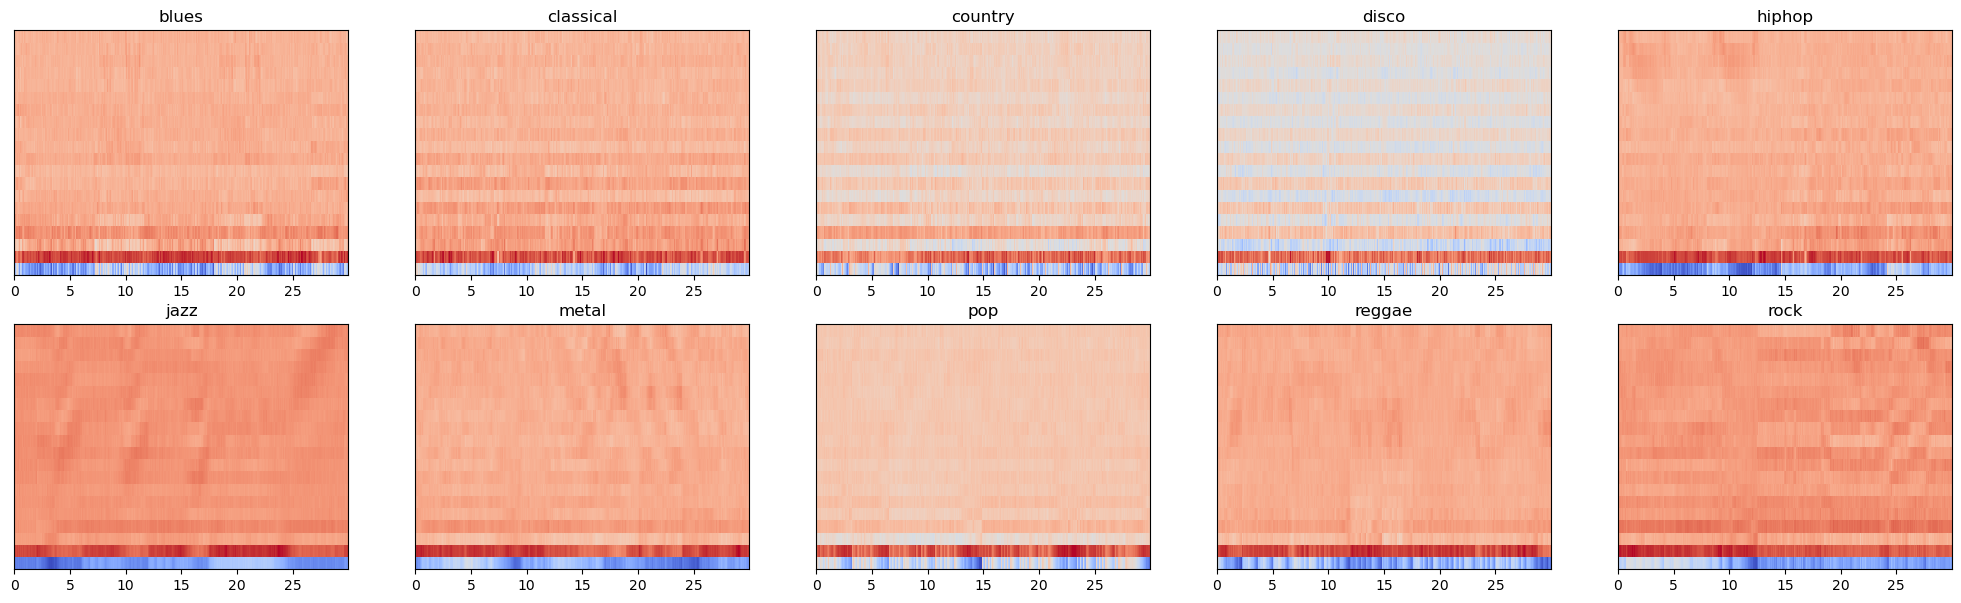

In [5]:
# Graficamos los MFCC de cadda genero para compararlos
plt.figure(figsize=(25, 7))

for k, v in dict_generos.items():
    plt.subplot(2, 5, v+1)
    mfcc = librosa.feature.mfcc(y=raw_audios[audio_slection*(v+1)], sr=sr, n_mfcc=20)
    librosa.display.specshow(mfcc, x_axis='time', sr=sr)
    plt.xlabel('')
    plt.title(k)

#### Chroma

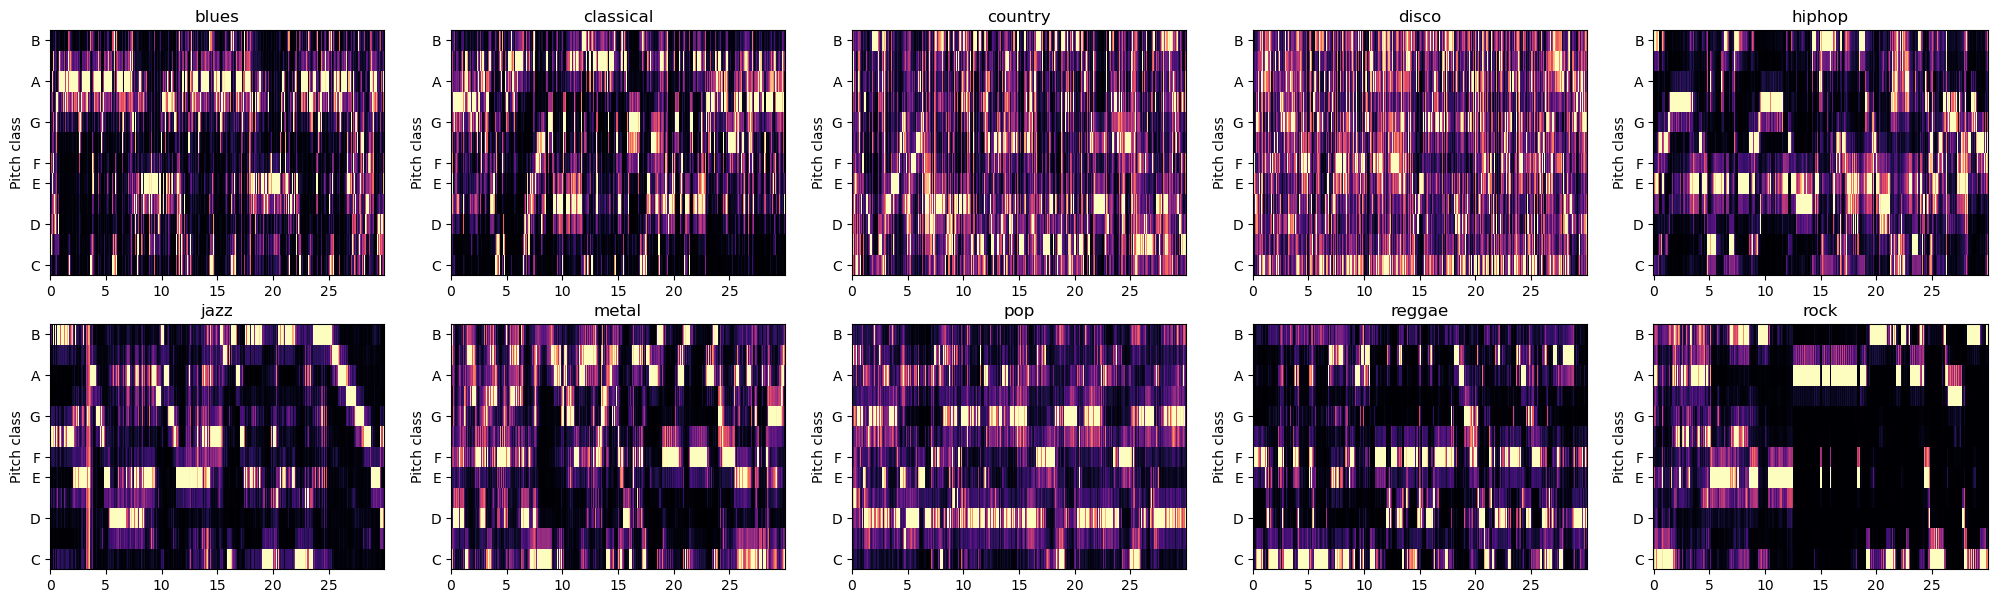

In [6]:
# Graficamos los Chroma de cadda genero para compararlos
plt.figure(figsize=(25, 7))

for k, v in dict_generos.items():
    plt.subplot(2, 5, v+1)
    chroma = librosa.feature.chroma_stft(y=raw_audios[audio_slection*(v+1)], sr=sr)
    librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', sr=sr)
    plt.xlabel('')
    plt.title(k)

#### Spectral Centroid y Spectral Bandwidth

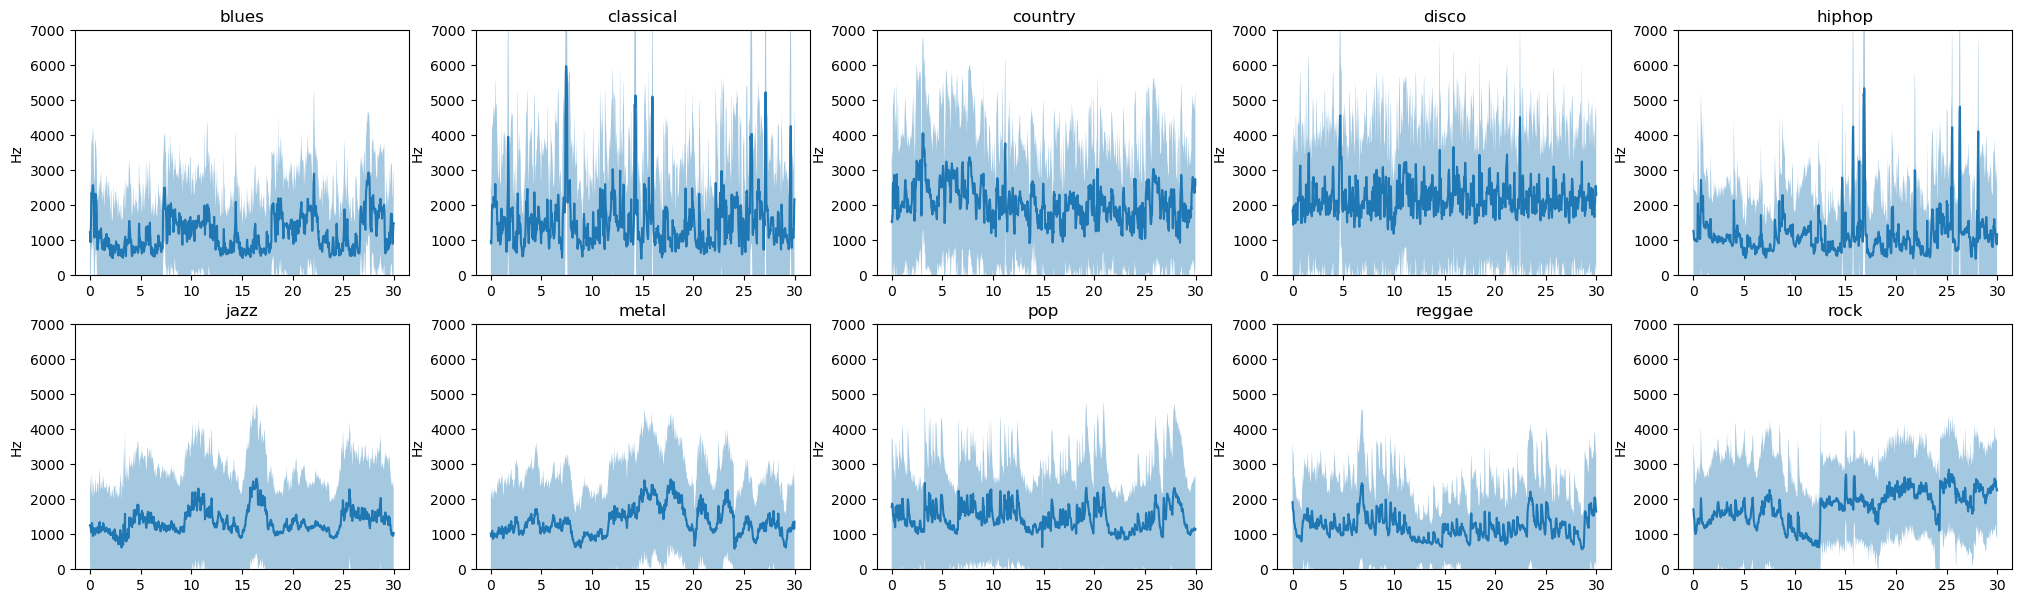

In [7]:
# Graficamos los el Spectral Centroid con su respectivo Bandwidth para cada genero y compararlos
plt.figure(figsize=(25, 7))

for k, v in dict_generos.items():
    plt.subplot(2, 5, v+1)
    spec_centroid = librosa.feature.spectral_centroid(y=raw_audios[audio_slection*(v+1)], sr=sr)
    spec_bandwidth = librosa.feature.spectral_bandwidth(y=raw_audios[audio_slection*(v+1)], sr=sr)

    t = librosa.times_like(spec_centroid)
    plt.plot(t, spec_centroid.T, label='Spectral centroid')
    plt.fill_between(t, np.maximum(0, spec_centroid[0] - spec_bandwidth[0]),
                np.minimum(spec_centroid[0] + spec_bandwidth[0], sr/2),
                alpha=0.4, label='Centroid +- Bandwidth')
    
    plt.ylim(0, 7000)
    plt.xlabel('')
    plt.ylabel('Hz')
    plt.title(k)

#### Spectral Contrast

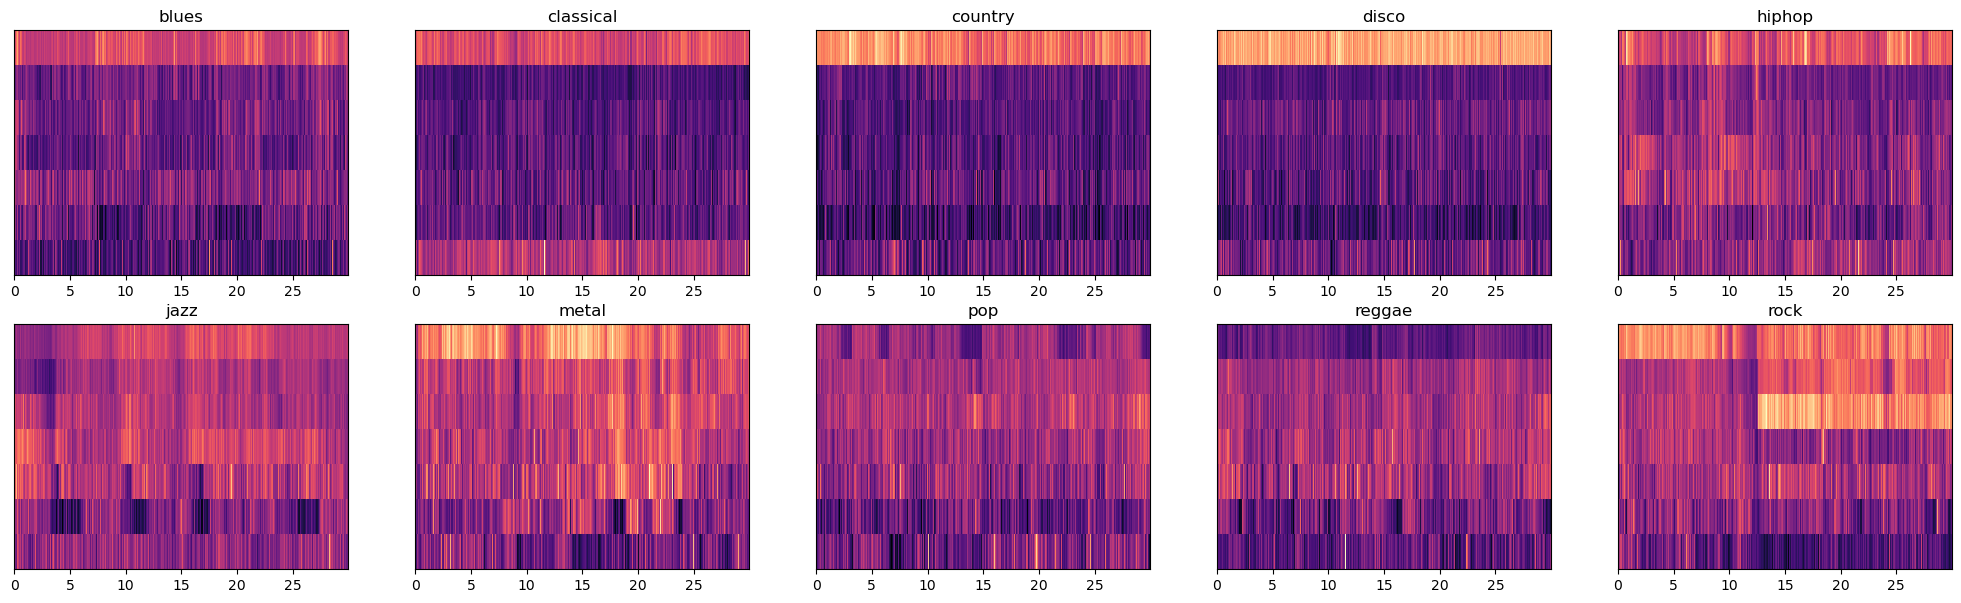

In [8]:
# Graficamos los el Spectral Contrast para cada genero
plt.figure(figsize=(25, 7))

for k, v in dict_generos.items():
    plt.subplot(2, 5, v+1)
    spec_contrast = librosa.feature.spectral_contrast(y=raw_audios[audio_slection*(v+1)], sr=sr)
    librosa.display.specshow(spec_contrast, x_axis='time', sr=sr)
    plt.xlabel('')
    plt.title(k)

#### Spectral Rolloff

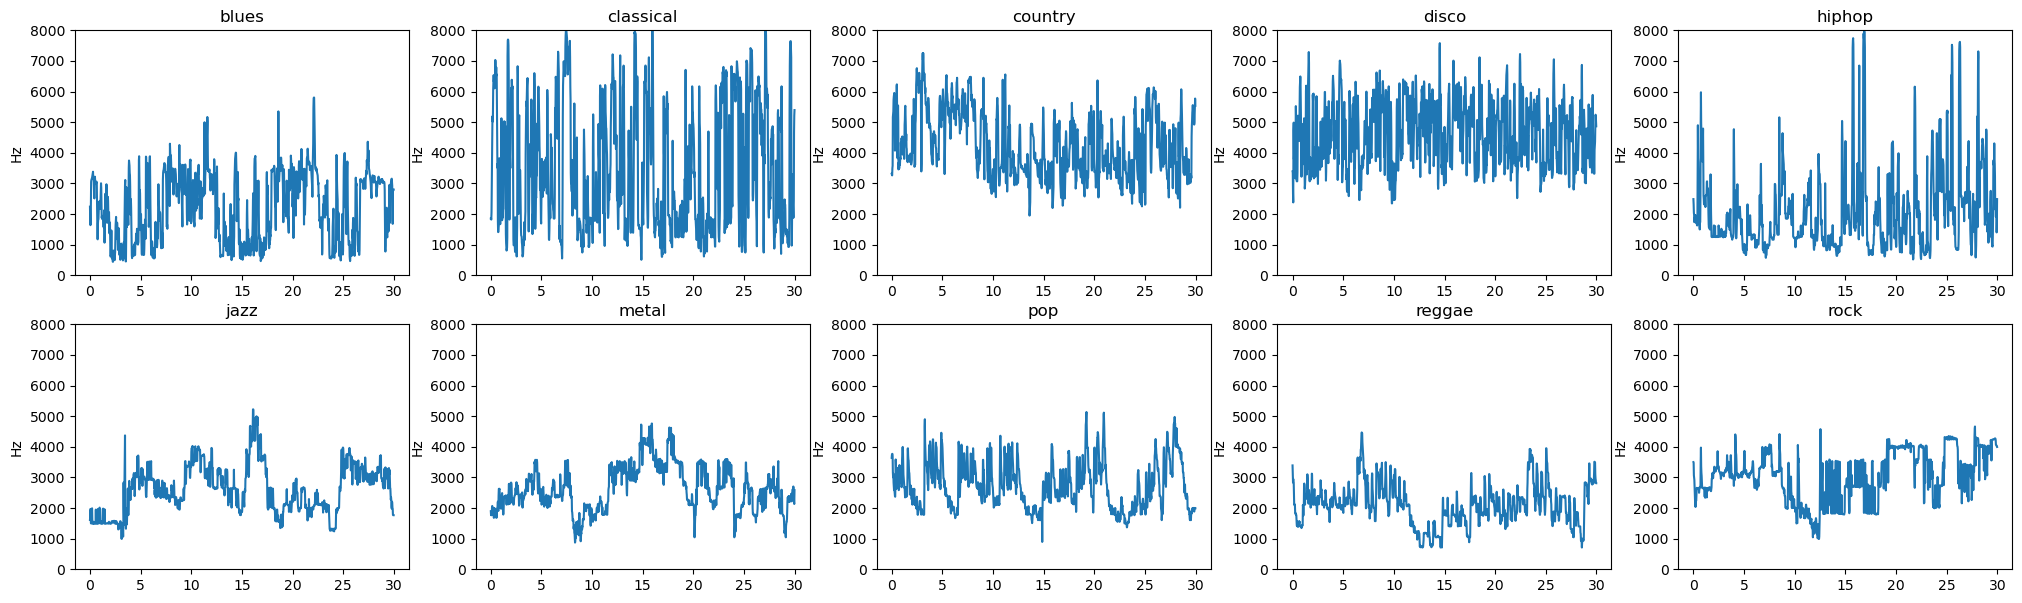

In [9]:
# Graficamos los el Spectral Rollof para cada genero
plt.figure(figsize=(25, 7))

for k, v in dict_generos.items():
    plt.subplot(2, 5, v+1)
    spec_rollof = librosa.feature.spectral_rolloff(y=raw_audios[audio_slection*(v+1)], sr=sr)

    t = librosa.times_like(spec_rollof)
    plt.plot(t, spec_rollof.T, label='Spectral Rollof')
    
    plt.ylim(0, 8000)
    plt.xlabel('')
    plt.ylabel('Hz')
    plt.title(k)

#### Zero Crossing Rate

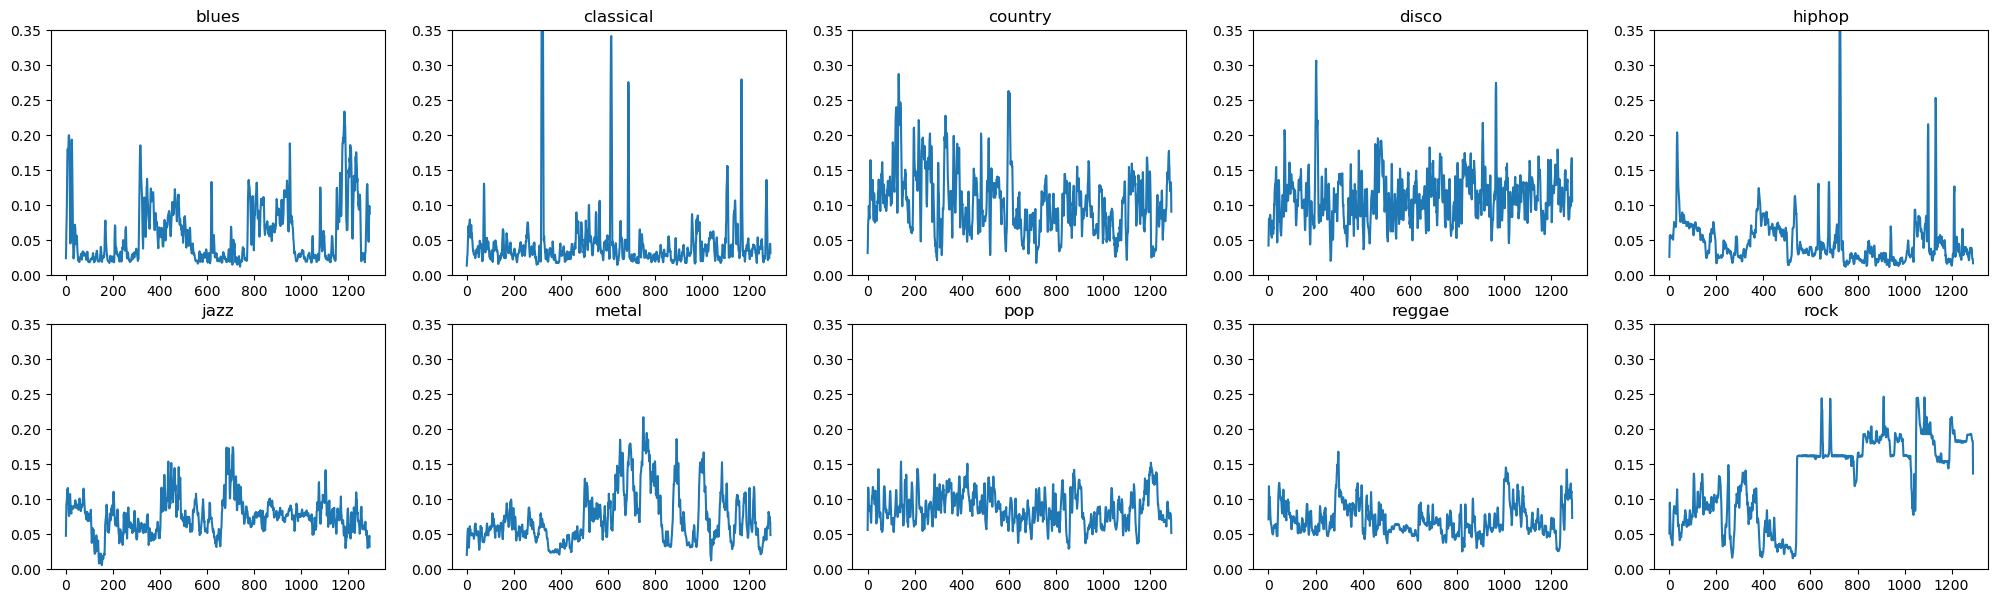

In [10]:
# Graficamos el Zero Crossing Rate para cada genero 
plt.figure(figsize=(25, 7))

for k, v in dict_generos.items():
    plt.subplot(2, 5, v+1)
    zcr = librosa.feature.zero_crossing_rate(y=raw_audios[audio_slection*(v+1)])

    plt.plot(zcr[0], label='ZCR')
    
    plt.ylim(0, .35)
    plt.xlabel('')
    plt.ylabel('')
    plt.title(k)

#### RMS

C:\Users\mig_c\AppData\Local\Temp\ipykernel_25252\4077765277.py:11: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(4e-3, 0)


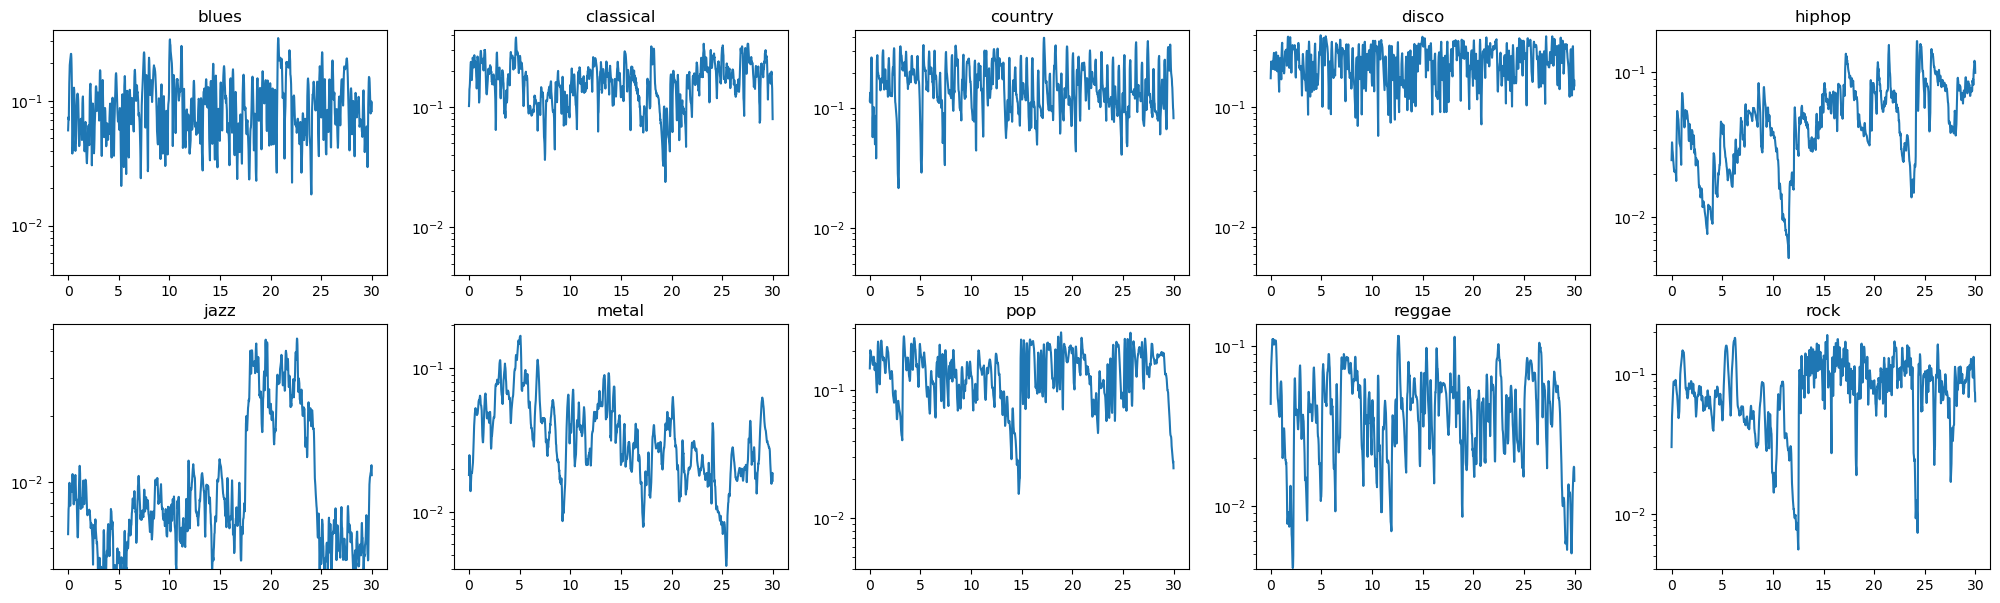

In [11]:
# Graficamos el RMS en escala logaritmica para cada genero 
plt.figure(figsize=(25, 7))

for k, v in dict_generos.items():
    plt.subplot(2, 5, v+1)
    rms = librosa.feature.rms(y=raw_audios[audio_slection*(v+1)])

    t = librosa.times_like(rms)
    plt.semilogy(t, rms[0], label='RMS Energy')
    
    plt.ylim(4e-3, 0)
    plt.xlabel('')
    plt.title(k)

### **DATA AUGMENTATION**

In [12]:
audios_5seg = []
generos_5seg = []

len_segmento = 5
overlap = 2

n_segmentos = len_segmento * sr
salto = (len_segmento - overlap) * sr
for audio, genero in zip(raw_audios, generos):
    for ini in range(0, len(audio) - n_segmentos + 1, salto):
        fin = ini + n_segmentos

        audios_5seg.append(audio[ini:fin])
        generos_5seg.append(genero)

audios_5seg = np.array(audios_5seg)
generos_5seg = np.array(generos_5seg)

print("%s archivos de audios cargados."%len(audios_5seg))

8910 archivos de audios cargados.


In [13]:
# Liberamos memoria eliminando los array anteriores que ya no se usaran.
del raw_audios
del generos

### **Extraccion de Carcateristicas relevantes**

In [14]:
# Funcion definida para, dado un audio, extraer 8 de sus features relevantes x frame 
# como: MFCC (de 20), Chroma STFT, Spectral Centroid, Spectral Bandwidth,
# Spectral Contrast, Spectral Rollof, Zero Crossing Rate y RMS.
# Dando como salida un Array de 44 dimensiones conteniendo todos estos features.
def extract_features(y):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20) # 20 dimensiones x frame
    chroma = librosa.feature.chroma_stft(y=y, sr=sr) # 12 dimensiones x frame
    spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr) # 1 dimension x frame
    spec_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr) # 1 dimension x frame
    spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr) # 7  dimensiones x frame
    spec_rollof = librosa.feature.spectral_rolloff(y=y, sr=sr) # 1 dimension x frame
    zcr = librosa.feature.zero_crossing_rate(y=y) # 1 dimension x frame
    rms = librosa.feature.rms(y=y) # 1 dimension x frame

    # Resultado Array de 44 dimensiones  x frame.
    return np.concatenate(
                    (
                        mfcc,
                        chroma,
                        spec_centroid,
                        spec_bandwidth,
                        spec_contrast,
                        spec_rollof,
                        zcr,
                        rms
                    )
                    , axis=0
                )

# Se extraen los features de cada audio usando la funcion
# y se almacenan en una lista
X_features = []
for y in audios_5seg:
    features = extract_features(y)
    X_features.append(features)

# Se transofrma la lista en Array
X_features = np.array(X_features)

In [15]:
print(X_features.shape)

(8910, 44, 216)


### **SPLIT TRAIN-TEST**

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X_features, generos_5seg, test_size=0.25, random_state=1907)

print('x_train, y_train shapes:', x_train.shape, y_train.shape)
print('x_test, y_test shapes:', x_test.shape, y_test.shape)

x_train, y_train shapes: (6682, 44, 216) (6682,)
x_test, y_test shapes: (2228, 44, 216) (2228,)


### **NORMALIZACION DE DATOS**

In [17]:
scaler = MinMaxScaler()
n_sample, n_features, n_steps = x_train.shape

x_train = scaler.fit_transform(x_train.reshape(n_sample, -1)).reshape(n_sample, n_features, n_steps)
x_test = scaler.transform(x_test.reshape(x_test.shape[0], -1)).reshape(x_test.shape[0], n_features, n_steps)

dump(scaler, 'minmax_scaler.save', compress=True)

['minmax_scaler.save']

### **CNN**

In [18]:
cnn = tf.keras.models.Sequential(name='CNN_MusicGenreClassificacion')

## Convolucional 1
cnn.add(layers.Conv2D(filters=32, input_shape=(44, 216, 1), kernel_size=3, activation='relu', name='conv_1'))
cnn.add(layers.MaxPool2D(pool_size=(2, 2), name='pool_1'))
cnn.add(layers.BatchNormalization(name='bacthNorm_1'))
cnn.add(layers.Dropout(0.1))

## Convolucional 2
cnn.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu', name='conv_2'))
cnn.add(layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))
cnn.add(layers.BatchNormalization(name='bacthNorm_2'))
cnn.add(layers.Dropout(0.2, name='dropOut_2'))

## Convolucional 3
cnn.add(layers.Conv2D(filters=128, kernel_size=3, activation='relu', name='conv_3'))
cnn.add(layers.MaxPool2D(pool_size=(2, 2), name='pool_3'))
cnn.add(layers.BatchNormalization(name='bacthNorm_3'))
cnn.add(layers.Dropout(0.3, name='dropOut_3'))


# Flattening
cnn.add(layers.Flatten(name='flatten'))

# Fully-connected
cnn.add(layers.Dense(128, activation='relu', name='dense_1'))
cnn.add(layers.BatchNormalization(name='bacthNorm_4'))
cnn.add(layers.Dropout(0.6, name='dropOut_4'))

cnn.add(layers.Dense(10, activation='softmax', name='outputs'))

c:\Users\mig_c\miniconda3\envs\tfm_music\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
cnn.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
cnn.summary()

Model: "CNN_MusicGenreClassificacion"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 42, 214, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 21, 107, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bacthNorm_1                     │ (None, 21, 107, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 107, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 19, 105, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 9, 52, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bacthNorm_2                     │ (None, 9, 52, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropOut_2 (Dropout)             │ (None, 9, 52, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 7, 50, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 3, 25, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bacthNorm_3                     │ (None, 3, 25, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropOut_3 (Dropout)             │ (None, 3, 25, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     1,228,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bacthNorm_4                     │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropOut_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,324,298 (5.05 MB)

 Trainable params: 1,323,594 (5.05 MB)

 Non-trainable params: 704 (2.75 KB)

In [21]:
checkpoint = keras.callbacks.ModelCheckpoint('CNN_MusicGenreClassificacion.keras', monitor='val_accuracy', save_best_only=True)

history = cnn.fit(x_train,
          y_train,
          epochs=30,
          batch_size=64,
          validation_split=0.2,
          verbose=1,
          callbacks=[checkpoint])

Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.2899 - loss: 2.3895 - val_accuracy: 0.1743 - val_loss: 6.8209
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 16s 188ms/step - accuracy: 0.5078 - loss: 1.3809 - val_accuracy: 0.1578 - val_loss: 6.6855
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 16s 189ms/step - accuracy: 0.6080 - loss: 1.1250 - val_accuracy: 0.2049 - val_loss: 7.7620
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 16s 186ms/step - accuracy: 0.6687 - loss: 0.9575 - val_accuracy: 0.1930 - val_loss: 5.6231
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 184ms/step - accuracy: 0.7218 - loss: 0.8153 - val_accuracy: 0.1803 - val_loss: 6.8318
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 16s 191ms/step - accuracy: 0.7461 - loss: 0.7403 - val_accuracy: 0.2872 - val_loss: 3.3165
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 17s 196ms/step - accuracy: 0.7992 - loss: 0.6007 - val_accuracy: 0.3366 - val_loss: 2.7018
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 16s 187ms/step - accuracy: 0.8229 - loss: 0.5213 - val_accu

In [22]:
cnn_best = load_model('CNN_MusicGenreClassificacion.keras')

results = cnn_best.evaluate(x_train, y_train, verbose=0, batch_size=1000)
print('Train Loss: {}'.format(results[0]))
print('Train Accuracy: {}'.format(results[1]))

print('--------------------------------------------------------')

results = cnn_best.evaluate(x_test, y_test, verbose=0, batch_size=1000)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Train Loss: 0.22200869023799896
Train Accuracy: 0.9440287351608276
--------------------------------------------------------
Test Loss: 0.9615017175674438
Test Accuracy: 0.7594255208969116


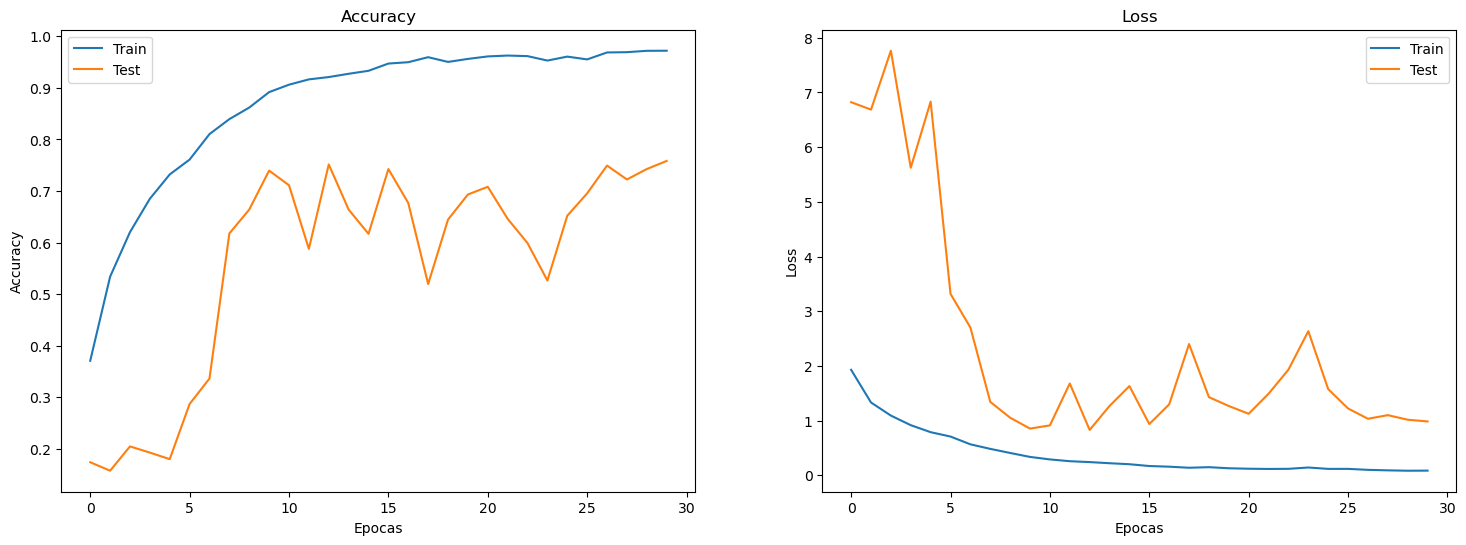

In [23]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Accuracy')
plt.xlabel('Epocas')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Loss')
plt.xlabel('Epocas')
plt.ylabel('Loss')
plt.legend()

70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step


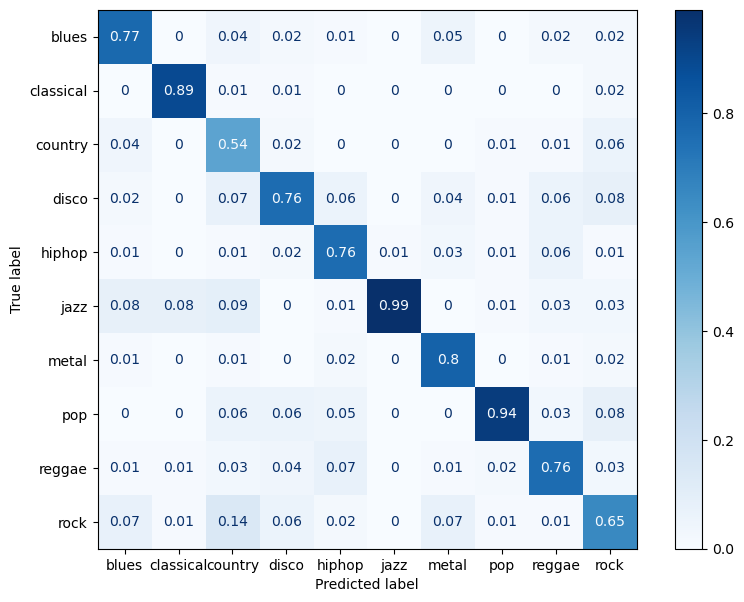

In [24]:
y_prediction = np.argmax(cnn_best.predict(x_test), axis=1)

cm = confusion_matrix(y_test, y_prediction , normalize='pred').round(2)

fig, ax = plt.subplots(figsize=(10,7))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dict_generos).plot(cmap=plt.cm.Blues, ax=ax)

### **CRNN**

In [25]:
crnn = tf.keras.models.Sequential(name='CRNN_MusicGenreClassificacion')

## Convolucional 1
crnn.add(layers.Conv2D(filters=32,  input_shape=(44, 216, 1), kernel_size=3, activation='relu', name='conv_1'))
crnn.add(layers.MaxPool2D(pool_size=(2, 2), name='pool_1'))
crnn.add(layers.BatchNormalization(name='bath_norm_1'))
crnn.add(layers.Dropout(0.1, name='dropOut_1'))

## Convolucional 2
crnn.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu', name='conv_2'))
crnn.add(layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))
crnn.add(layers.BatchNormalization(name='bath_norm_2'))
crnn.add(layers.Dropout(0.2, name='dropOut_2'))

## Convolucional 3
crnn.add(layers.Conv2D(filters=128, kernel_size=3, activation='relu', name='conv_3'))
crnn.add(layers.MaxPool2D(pool_size=(2, 2), name='pool_3'))
crnn.add(layers.BatchNormalization(name='bath_norm_3'))
crnn.add(layers.Dropout(0.3, name='dropOut_3'))


## Redimensionamiento
crnn.add(layers.Reshape((-1, 128), name='reshape_1'))

## Capas Recurrentes
crnn.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True), name='lstm_bidirectional_1'))
crnn.add(layers.Bidirectional(layers.LSTM(128, return_sequences=False), name='lstm_bidirectional_2'))

## Fully-connected
crnn.add(layers.Dense(128, activation='relu', name='dense_1'))
crnn.add(layers.BatchNormalization(name='bath_norm_4'))
crnn.add(layers.Dropout(0.6, name='dropOut_4'))

crnn.add(layers.Dense(10, activation='softmax', name='outputs'))

c:\Users\mig_c\miniconda3\envs\tfm_music\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
crnn.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
crnn.summary()

Model: "CRNN_MusicGenreClassificacion"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 42, 214, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 21, 107, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bath_norm_1                     │ (None, 21, 107, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropOut_1 (Dropout)             │ (None, 21, 107, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 19, 105, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 9, 52, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bath_norm_2                     │ (None, 9, 52, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropOut_2 (Dropout)             │ (None, 9, 52, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 7, 50, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 3, 25, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bath_norm_3                     │ (None, 3, 25, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropOut_3 (Dropout)             │ (None, 3, 25, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_bidirectional_1            │ (None, 75, 256)        │       263,168 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_bidirectional_2            │ (None, 256)            │       394,240 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bath_norm_4                     │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropOut_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 785,674 (3.00 MB)

 Trainable params: 784,970 (2.99 MB)

 Non-trainable params: 704 (2.75 KB)

In [27]:
checkpoint = keras.callbacks.ModelCheckpoint('CRNN_MusicGenreClassificacion.keras', monitor='val_accuracy', save_best_only=True)

history_crnn = crnn.fit(x_train,
          y_train,
          epochs=30,
          batch_size=64,
          validation_split=0.2,
          verbose=1,
          callbacks=[checkpoint])

Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 40s 382ms/step - accuracy: 0.2865 - loss: 2.2434 - val_accuracy: 0.0965 - val_loss: 2.5519
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 28s 329ms/step - accuracy: 0.4962 - loss: 1.4178 - val_accuracy: 0.0965 - val_loss: 2.9878
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 27s 326ms/step - accuracy: 0.5452 - loss: 1.2481 - val_accuracy: 0.0965 - val_loss: 2.9931
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 27s 324ms/step - accuracy: 0.6204 - loss: 1.0676 - val_accuracy: 0.1586 - val_loss: 3.8764
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 27s 327ms/step - accuracy: 0.6909 - loss: 0.9086 - val_accuracy: 0.2162 - val_loss: 3.3397
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 28s 329ms/step - accuracy: 0.7368 - loss: 0.7870 - val_accuracy: 0.2880 - val_loss: 2.5076
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 27s 323ms/step - accuracy: 0.7701 - loss: 0.6836 - val_accuracy: 0.3972 - val_loss: 2.1781
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 27s 326ms/step - accuracy: 0.7951 - loss: 0.6271 - val_accu

In [28]:
crnn_best = load_model('CRNN_MusicGenreClassificacion.keras')

results = crnn_best.evaluate(x_train, y_train, verbose=0, batch_size=1000)
print('Train Loss: {}'.format(results[0]))
print('Train Accuracy: {}'.format(results[1]))

print('--------------------------------------------------------')

results = crnn_best.evaluate(x_test, y_test, verbose=0, batch_size=1000)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Train Loss: 0.14653711020946503
Train Accuracy: 0.957348108291626
--------------------------------------------------------
Test Loss: 0.5879805088043213
Test Accuracy: 0.8559246063232422


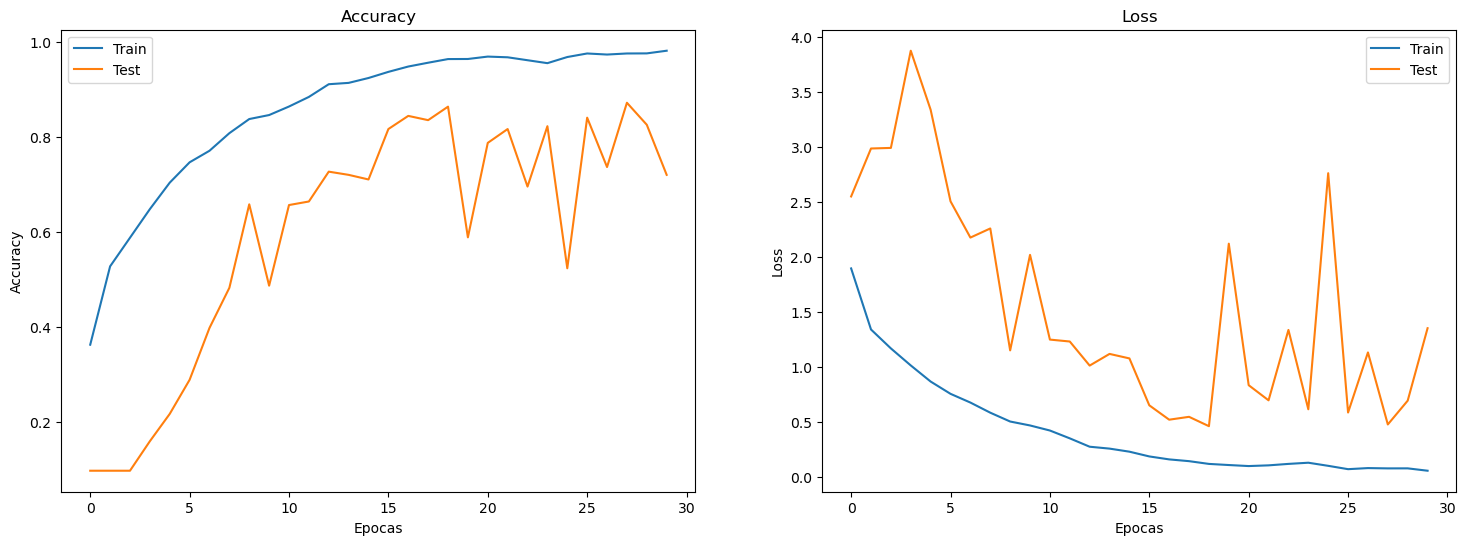

In [29]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(history_crnn.history['accuracy'], label='Train')
plt.plot(history_crnn.history['val_accuracy'], label='Test')
plt.title('Accuracy')
plt.xlabel('Epocas')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_crnn.history['loss'], label='Train')
plt.plot(history_crnn.history['val_loss'], label='Test')
plt.title('Loss')
plt.xlabel('Epocas')
plt.ylabel('Loss')
plt.legend()

70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step


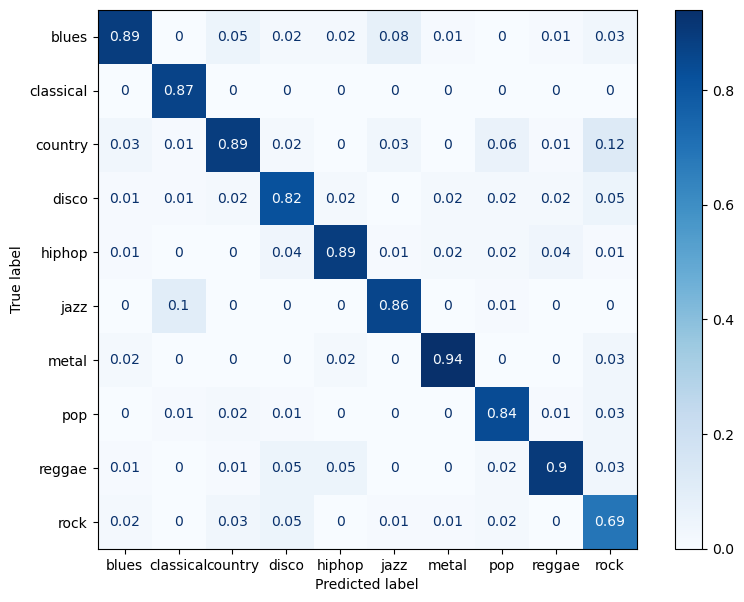

In [30]:
y_prediction = np.argmax(crnn_best.predict(x_test), axis=1)
cm = confusion_matrix(y_test, y_prediction , normalize='pred').round(2)

fig, ax = plt.subplots(figsize=(10,7))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dict_generos).plot(cmap=plt.cm.Blues, ax=ax)

### **SISTEMA DE RECOMENDACIONES DE CANCIONES SIMILARES**

In [31]:
# Cargamos el mejor modelo guardado de CRNN para Clasificacion de Generos Musicales
crnn_best = load_model('CRNN_MusicGenreClassificacion.keras')
crnn_best.set_weights(crnn.get_weights())

# Eliminamos la ultima capa 'softmax' del la red anterior
# Con esto, la salida de la nueva red seran los Embeddings de cada cancion
crnn_rec = Model(crnn_best.inputs, crnn_best.layers[-2].output, name='CRNN_MusicRecomendation')
crnn_rec.summary()

Model: "CRNN_MusicRecomendation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 44, 216, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 42, 214, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 21, 107, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bath_norm_1                     │ (None, 21, 107, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropOut_1 (Dropout)             │ (None, 21, 107, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 19, 105, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 9, 52, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bath_norm_2                     │ (None, 9, 52, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropOut_2 (Dropout)             │ (None, 9, 52, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 7, 50, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 3, 25, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bath_norm_3                     │ (None, 3, 25, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropOut_3 (Dropout)             │ (None, 3, 25, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_bidirectional_1            │ (None, 75, 256)        │       263,168 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_bidirectional_2            │ (None, 256)            │       394,240 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bath_norm_4                     │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropOut_4 (Dropout)             │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 784,384 (2.99 MB)

 Trainable params: 783,680 (2.99 MB)

 Non-trainable params: 704 (2.75 KB)

In [32]:
# Calculamos todos los Embeddings del universo de canciones de 5seg.
all_embeddings = []
for song in X_features:
    emb = crnn_rec.predict(scaler.transform(song.reshape(1, -1)).reshape(1, 44, 216), verbose=0).flatten()

    all_embeddings.append(emb)
    
# Transformamos la lista en un Array
all_embeddings = np.array(all_embeddings) 

# Guardamos el array en un archivo para una carga posterior mas rapida y eficiente
np.save('all_embeddings_audios_5seg.npy', all_embeddings)

#### Validacion del Recomendador de Canciones Similares

In [33]:
# Escogemos un audio de 5seg aleatorio del universo inicial
index = random.randint(0, len(audios_5seg))
input_song = audios_5seg[index]

# Extraemmos sus caracterisiticas principales que son entradas para la Red
input_song_feautres = extract_features(input_song)

# Obtenemos el Enbedding de la cancion usando la Red entrenada 
emb = crnn_rec.predict(scaler.transform(input_song_feautres.reshape(1, -1)).reshape(1, 44, 216)).flatten()

# Mediante la Similitud del Coseno obtenemos las 3 canciones mas parecidas a la escogida
similarities = cosine_similarity([emb], list(map(lambda x : x.flatten(), all_embeddings)))[0]
top3 = np.argsort(similarities)[::-1][:3] # Indices del Top 3 de canciones similares 
top3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


array([315, 325, 297], dtype=int64)

In [34]:
print("Audio de entrada: ")
print("Idx: %s (genero => %s)"%(index, inv_dict_generos[generos_5seg[index]]))
ipd.Audio(data=input_song, rate=sr)

Audio de entrada: 
Idx: 315 (genero => blues)


In [35]:
print("Recomendacion 1: ")
print("Idx: %s (genero => %s)"%(top3[0], inv_dict_generos[generos_5seg[top3[0]]]))
ipd.Audio(data=audios_5seg[top3[0]], rate=sr)

Recomendacion 1: 
Idx: 315 (genero => blues)


In [36]:
print("Recomendacion 2: ")
print("Idx: %s (genero => %s)"%(top3[1], inv_dict_generos[generos_5seg[top3[1]]]))
ipd.Audio(data=audios_5seg[top3[1]], rate=sr)

Recomendacion 2: 
Idx: 325 (genero => blues)


In [37]:
print("Recomendacion 3: ")
print("Idx: %s (genero => %s)"%(top3[2], inv_dict_generos[generos_5seg[top3[2]]]))
ipd.Audio(data=audios_5seg[top3[2]], rate=sr)

Recomendacion 3: 
Idx: 297 (genero => blues)
